# RAG Evaluation

To evaluate a RAG pipeline, we need : 
- a RAG pipeline (Retriever - LLM )
- a Vectorial Databse (with associated embedding model)
- a test dataset with Q&A. 

In [1]:
#load vectorial dataset 
!mc cp s3/projet-llm-insee-open-data/data/chroma_database/chroma_db  ./src/data --recursive
#load test dataset 
!mc cp s3/projet-llm-insee-open-data/data/eval_data/eval_dataset.csv ./src/data

]11;?\mc: Configuration written to `/home/onyxia/.mc/config.json`. Please update your access credentials.
mc: Successfully created `/home/onyxia/.mc/share`.
mc: Initialized share uploads `/home/onyxia/.mc/share/uploads.json` file.
mc: Initialized share downloads `/home/onyxia/.mc/share/downloads.json` file.
...ataset.csv: 240.80 KiB / 240.80 KiB ┃▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓┃ 1.77 MiB/s 0s]11;?\

In [ ]:
#create prompt for chat template 
RAG_PROMPT_TEMPLATE = """
<s>[INST] 
Tu es un assistant spécialisé dans la statistique publique répondant aux questions d'agent de l'INSEE. 
Réponds en Français seulement.
Utilise les informations obtenues dans le contexte, réponds de manière argumentée à la question posée.
La réponse doit être développée et citer ses sources.

Si tu ne peux pas induire ta réponse du contexte, ne réponds pas. 
Voici le contexte sur lequel tu dois baser ta réponse : 
Contexte: {context}
        ---
Voici la question à laquelle tu dois répondre : 
Question: {question}
[/INST]
"""

#load Embedding model 
hf_embeddings = HuggingFaceEmbeddings(model_name=EMB_MODEL_NAME, model_kwargs={"device": EMB_DEVICE})
#load vector database
vectorstore = Chroma(collection_name="insee_data", embedding_function=hf_embeddings, persist_directory=str(DB_DIR))
#set up a retriever 
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs = {"k":10})
#generate prompt template
prompt = PromptTemplate(input_variables=["context", "question"], template=RAG_PROMPT_TEMPLATE)

#create a pipeline with tokenizer and LLM
llm = build_llm_model()

langchain ChromaDB class support batch querying => ask multiple questions and recieved multiple documents

In [128]:
from ragatouille import RAGPretrainedModel
from langchain_core.vectorstores import VectorStore
from langchain_core.documents import Document
from typing import Optional, Tuple, List

def answer_with_rag(
    questions: list[str],
    llm_model,
    knowledge_index: VectorStore,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 7,
) -> Tuple[str, List[Document]]:

    """Answer a batch of questions using RAG with the given knowledge index.
    return a batch of answers and relevant documents. 
    """
    batch_final_prompt = []
    batch_relevant_documents = []
    for q in questions:
        # Gather documents with retriever
        relevant_docs = knowledge_index.similarity_search(query=q, k=num_retrieved_docs)
        relevant_docs = [doc.page_content for doc in relevant_docs]  # keep only the text

        # Optionally rerank results
        if reranker:
            relevant_docs = reranker.rerank(q, relevant_docs, k=num_docs_final)
            relevant_docs = [doc["content"] for doc in relevant_docs]

        relevant_docs = relevant_docs[:num_docs_final]

        # Build the final prompt
        context = "\nExtracted documents:\n"
        context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)])

        final_prompt = RAG_PROMPT_TEMPLATE.format(question=q, context=context)

        batch_final_prompt.append(final_prompt)
        batch_relevant_documents.append(relevant_docs)

    # Redact an answer
    batch_answer = llm_model.batch(batch_final_prompt)
    batch_answer = [out.replace("\nA: ", "") for out in batch_answer] #clean up 
    return batch_answer, batch_relevant_documents

In [143]:
import datasets
from tqdm import tqdm
import json
import time 
import numpy as np

def run_rag_tests(
    eval_dataset: datasets.Dataset,
    llm,
    knowledge_index: VectorStore,
    output_file: str,
    reranker: Optional[RAGPretrainedModel] = None,
    verbose: Optional[bool] = True,
    test_settings: Optional[str] = None,  # To document the test settings used
    batch_size = 2
):
    """Runs RAG tests on the given dataset and saves the results to the given output file."""
    try:  # load previous generations if they exist
        with open(output_file, "r") as f:
            outputs = json.load(f)
    except:
        outputs = []

    num_rows = len(eval_dataset["train"])

    for batch_start in tqdm(range(0, num_rows, batch_size)):

        # Adjust batch end to handle the last incomplete batch
        batch_end = min(batch_start + batch_size, num_rows)
        batch_examples = eval_dataset["train"][batch_start:batch_end]
        #eval_dataset is a HF dataset then a slice return a sub dataset (a dict {'context' : [...,...]}) 
        #no rows like in pandas dataframe. 
        batch_questions = batch_examples["question"]

        indices_to_remove = [] #the question have been already asked
        already_answered = set([output["question"] for output in outputs]) if len(outputs) > 0 else {}
        for i, question in enumerate(batch_questions):
            if question in already_answered: 
                indices_to_remove.append(i)
                
        batch_examples = {key: [value for i, value in enumerate(values) if i not in indices_to_remove] for key, values in batch_examples.items()}
        #slice to only select the questions that have never been answered. 
        batch_questions = batch_examples["question"]
        
        batch_answers, batch_relevant_docs = answer_with_rag(batch_questions, llm, knowledge_index, reranker=reranker)
        for i , (question, answer , relevant_docs) in enumerate(zip(batch_questions, batch_answers, batch_relevant_docs)):
            
            if verbose:
                print("=======================================================")
                print(f"Question: {question}")
                print(f"Answer: {answer}")
                print(f'True answer: {batch_examples["answer"][i]}')
            
            result = {
                "question": question,
                "true_answer": batch_examples["answer"][i],
                "source_doc": batch_examples["source_doc"][i],
                "generated_answer": answer,
                "retrieved_docs": [doc for doc in relevant_docs],
            }
            if test_settings:
                result["test_settings"] = test_settings
            outputs.append(result)

            with open(output_file, "w") as f:
                json.dump(outputs, f)    

In [126]:
#! mc cp s3/projet-llm-insee-open-data/data/eval_data/eval_dataset.csv ./src/data/
eval_dataset = datasets.load_dataset('csv', data_files="src/data/eval_dataset.csv",) #load eval dataset

In [ ]:
run_rag_tests(eval_dataset = eval_dataset,
                llm = llm,
                knowledge_index = vectorstore,
                output_file = "test_generated_ans.json",
                reranker = None,
                verbose=True,
                test_settings = MODEL_NAME,
                batch_size = 5
                )

**Get access to test_generated_ans.json** : mc cp s3/projet-llm-insee-open-data/data/eval_data/test_generated_ans.json ./src/data/

**Write an Evaluation prompt for a Critique LLM.**

In [81]:
EVALUATION_PROMPT = """
<s><|user|>
###Description de la tâche :
Une instruction (pouvant inclure une Entrée à l'intérieur), une réponse à évaluer, une réponse de référence qui obtient un score de 5, et une grille de notation représentant un critère d'évaluation sont fournis.

###L'instruction à évaluer :
{instruction}

###Réponse à évaluer :
{response}

###Réponse de référence (Score 5) :
{reference_answer}

###Grille de notation :
[La réponse est-elle correcte, précise et factuelle par rapport à la réponse de référence ?]
Score 1 : La réponse est complètement incorrecte, imprécise et/ou non factuelle.
Score 2 : La réponse est principalement incorrecte, imprécise et/ou non factuelle.
Score 3 : La réponse est quelque peu correcte, précise et/ou factuelle.
Score 4 : La réponse est principalement correcte, précise et factuelle.
Score 5 : La réponse est complètement correcte, précise et factuelle.

1. Rédigez un feedback détaillé évaluant la qualité de la réponse strictement en fonction de la grille de notation donnée, sans évaluation générale.
2. Après avoir rédigé un feedback, attribuez un score qui est un entier entre 1 et 5. Vous devez vous référer à la grille de notation.
3. Le format de sortie devrait ressembler à ce qui suit : "Feedback: {{écrire un feedback pour le critère}} [RESULTAT] {{un nombre entier entre 1 et 5}}"
4. Veuillez ne pas générer d'autres ouvertures, fermetures et explications. Assurez-vous d'inclure la balise [RESULTAT] dans votre sortie.
<|end|>
<|assistant|>
Feedback: """

In [11]:
from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema import SystemMessage


evaluation_prompt_template = ChatPromptTemplate.from_messages(
    [
        SystemMessage(content="Tu es un modèle de langue évaluateur juste"),
        HumanMessagePromptTemplate.from_template(EVALUATION_PROMPT),
    ]
)

In [5]:
print(evaluation_prompt_template)

input_variables=['instruction', 'reference_answer', 'response'] messages=[SystemMessage(content='Tu es un modèle de langage évaluateur juste'), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['instruction', 'reference_answer', 'response'], template='\n<s><|user|>\n###Description de la tâche :\nUne instruction (pouvant inclure une Entrée à l\'intérieur), une réponse à évaluer, une réponse de référence qui obtient un score de 5, et une grille de notation représentant un critère d\'évaluation sont fournis.\n1. Rédigez un feedback détaillé évaluant la qualité de la réponse strictement en fonction de la grille de notation donnée, sans évaluation générale.\n2. Après avoir rédigé un feedback, attribuez un score qui est un entier entre 1 et 5. Vous devez vous référer à la grille de notation.\n3. Le format de sortie devrait ressembler à ce qui suit : "Feedback: {{écrire un feedback pour le critère}} [RESULTAT] {{un nombre entier entre 1 et 5}}"\n4. Veuillez ne pas générer d\'a

**Evaluate the generated answer**

To assess the generated answer by our RAG (using Mistral 8b), we use the open source alternative of GPT4 evaluation called Prometheus-13b-v1.0 part of the prometheus-eval LLM family. It has been fined tune on 100K feedback messages 

In [8]:
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig, BitsAndBytesConfig

#teacher_name = "prometheus-eval/prometheus-7b-v2.0"
teacher_name = "microsoft/Phi-3-mini-128k-instruct" 

#load LLM config 
teacher_config = AutoConfig.from_pretrained(teacher_name, trust_remote_code=True)

#load quantization config 
teacher_quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype="float16",
        bnb_4bit_use_double_quant=False,
    )
#load llm tokenizer 
teacher_tokenizer = AutoTokenizer.from_pretrained(teacher_name, use_fast=True, device_map='auto')

#load llm 
teacher_model = AutoModelForCausalLM.from_pretrained(teacher_name,
        config=teacher_config,
        device_map="auto",
        quantization_config = teacher_quantization_config ,
        trust_remote_code=True
    )


tokenizer_config.json:   0%|          | 0.00/3.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


modeling_phi3.py:   0%|          | 0.00/73.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attenton` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.


model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

In [10]:
#create a pipeline for Evaluator Model 
from transformers import pipeline
from langchain_community.llms.huggingface_pipeline import HuggingFacePipeline
pipeline_HF = pipeline(task="text-generation", # TextGenerationPipeline HF pipeline
                model=teacher_model, 
                tokenizer=teacher_tokenizer,
                temperature=0.2, 
                return_full_text=False, 
                device_map="auto",
                do_sample=True,
            )
# Create a LangChain Runnable pipeline 
evaluator_model = HuggingFacePipeline(pipeline=pipeline_HF, model_kwargs={"max_length": 4000})

In [104]:
import os 
from tqdm import tqdm 
import json 
import random

generation_args = {
    "return_full_text": False,
    "do_sample": True,
    'max_length': 10000
}

def evaluate_answers(
    answer_path: str,
    eval_chat_model : pipeline,
    evaluator_name: str,
    evaluation_prompt_template: str, 
    pipeline_args : dict = generation_args
) -> None:
    """Evaluates generated answers. Modifies the given answer file in place for better checkpointing."""
    answers = []
    if os.path.isfile(answer_path):  # load previous generations if they exist
        answers = json.load(open(answer_path, "r"))

    i = random.randint(0, len(answers))
    experiment = answers[i]

    for experiment in tqdm(answers):
        if f"eval_score_{evaluator_name}" in experiment:
            continue

        eval_prompt = evaluation_prompt_template.format(
            instruction=experiment["question"],
            response=experiment["generated_answer"],
            reference_answer=experiment["true_answer"],
        )

        try:
            eval_result = eval_chat_model(eval_prompt,**pipeline_args)
            feedback, score = eval_result[0]["generated_text"].split("[RESULTAT]")
        except Exception as e:
            print('Error:', e)
            print(eval_result)
            continue
        """
        print("feedback : ", feedback)
        print("score : ", score)
        """
        experiment[f"eval_score_{evaluator_name}"] = score
        experiment[f"eval_feedback_{evaluator_name}"] = feedback

        with open(answer_path, "w") as f:
            json.dump(answers, f)

In [105]:
evaluate_answers(
        answer_path = "/home/onyxia/work/llm-open-data-insee/src/data/test_generated_ans.json", 
        eval_chat_model = pipeline_HF,
        evaluator_name= teacher_name.replace("/","-"),
        evaluation_prompt_template = EVALUATION_PROMPT, 
        pipeline_args = generation_args
)

 74%|███████▍  | 57/77 [00:00<00:00, 92.60it/s]

Error: not enough values to unpack (expected 2, got 1)
[{'generated_text': ''}]
Error: Input length of input_ids is 2048, but `max_length` is set to 2048. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.
[{'generated_text': ''}]


100%|██████████| 77/77 [03:04<00:00,  2.40s/it]


**inspect the results**

In [106]:
import glob
import pandas as pd
outputs = []
for file in glob.glob("/home/onyxia/work/llm-open-data-insee/src/data/*.json"):
    output = pd.DataFrame(json.load(open(file, "r")))
    output["settings"] = file
    outputs.append(output)
result = pd.concat(outputs)

In [107]:
result["eval_score_microsoft-Phi-3-mini-128k-instruct"] = result["eval_score_microsoft-Phi-3-mini-128k-instruct"] .apply(lambda x: int(x) if isinstance(x, str) else 1)
result["eval_score_microsoft-Phi-3-mini-128k-instruct"]  = (result["eval_score_microsoft-Phi-3-mini-128k-instruct"] - 1 )/ 4

In [108]:
average_scores = result.groupby("settings")["eval_score_microsoft-Phi-3-mini-128k-instruct"].mean()
average_scores.sort_values()

settings
/home/onyxia/work/llm-open-data-insee/src/data/test_generated_ans.json    0.282468
Name: eval_score_microsoft-Phi-3-mini-128k-instruct, dtype: float64

In [109]:
result

,question,true_answer,source_doc,generated_answer,retrieved_docs,test_settings,eval_score_microsoft-Phi-3-mini-128k-instruct,eval_feedback_microsoft-Phi-3-mini-128k-instruct,settings
0,Quelle était la population du Territoire de la...,La population du Territoire de la Côte Ouest é...,https://www.insee.fr/fr/statistiques/1293858,La population du Territoire de la Côte Ouest n...,"[. Entre 2008 et 2013, le rythme annuel de pro...",mistralai/Mistral-7B-Instruct-v0.2,0.00,"\n\nLa réponse fournie n'est pas correcte, pré...",/home/onyxia/work/llm-open-data-insee/src/data...
1,Quelles mesures ont été mises en place pour pr...,"Des mesures telles que la loi Génisson (2001),...",https://www.insee.fr/fr/statistiques/1285800,"Dans le contexte fourni, plusieurs mesures ont...","[. Dans ce cadre, en juillet 2014, un premier ...",mistralai/Mistral-7B-Instruct-v0.2,0.50,\n\nLa réponse fournie présente une structure ...,/home/onyxia/work/llm-open-data-insee/src/data...
2,Quand Mayotte a-t-elle commencé à utiliser la ...,Mayotte a commencé à utiliser la méthode commu...,https://www.insee.fr/fr/statistiques/7728787,Mayotte a commencé à utiliser la méthode commu...,[Mayotte intègre désormais la méthode commune ...,mistralai/Mistral-7B-Instruct-v0.2,1.00,\n\nLa réponse fournie est directe et correspo...,/home/onyxia/work/llm-open-data-insee/src/data...
3,Combien d'emplois sont considérés comme liés a...,Pour les secteurs d'activités partiellement to...,https://www.insee.fr/fr/statistiques/1283777,"Dans le contexte fourni, les emplois liés au t...","[. L’emploi touristique englobe les activités,...",mistralai/Mistral-7B-Instruct-v0.2,0.00,\n\nLa réponse fournie ne correspond pas à la ...,/home/onyxia/work/llm-open-data-insee/src/data...
4,Quelle est la différence de nombre de décès en...,La différence de nombre de décès entre le 1er ...,https://www.insee.fr/fr/statistiques/5055298,La région de Bourgogne-Franche-Comté a enregis...,[. C’est particulièrement le cas pour avril 20...,mistralai/Mistral-7B-Instruct-v0.2,0.50,\n\nLa réponse donnée mentionne correctement l...,/home/onyxia/work/llm-open-data-insee/src/data...
...,...,...,...,...,...,...,...,...,...
72,Quelle est la différence de rémunération moyen...,La différence de rémunération moyenne entre le...,https://www.insee.fr/fr/statistiques/1372799,"Dans le contexte fourni, les documents indique...","[En France, les accords collectifs, négociés a...",mistralai/Mistral-7B-Instruct-v0.2,0.50,\n\nLa réponse fournie ne mentionne pas la dif...,/home/onyxia/work/llm-open-data-insee/src/data...
73,Quelle est la progression de l'emploi salarié ...,La progression de l'emploi salarié dans le sec...,https://www.insee.fr/fr/statistiques/4277983,"Dans le contexte fourni, il n'y a pas de donné...",[. Ce changement de source a pu entraîner une ...,mistralai/Mistral-7B-Instruct-v0.2,0.25,La réponse fournie ne correspond pas à la rép...,/home/onyxia/work/llm-open-data-insee/src/data...
74,Quelle est la tendance démographique de la pop...,La population régionale de Bourgogne-Franche-C...,https://www.insee.fr/fr/statistiques/5369489,La tendance démographique de la population rég...,[Si les tendances démographiques récentes se m...,mistralai/Mistral-7B-Instruct-v0.2,0.00,\n\nLa réponse fournie ne correspond pas à la ...,/home/onyxia/work/llm-open-data-insee/src/data...
75,Quels sont les sujets principaux traités dans ...,Les sujets principaux traités dans le rapport ...,https://www.insee.fr/fr/statistiques/2894036,"Le rapport annuel ""L'Économie française - Comp...",[L'économie française - Comptes et dossiers Éd...,mistralai/Mistral-7B-Instruct-v0.2,0.25,\n\nLa réponse fournie présente une synthèse d...,/home/onyxia/work/llm-open-data-insee/src/data...


# RAG Evaluation

Goal : This notebook aims to provide a code allowing to evaluate the generated answer of the RAG pipeline based on a reference dataset. It is inspired by RAGAS implementation of evaluation framework and relies on recent strong instruction fine tuned LLM with a long context size in order to evaluate the results. 

The following code exploit the projet function to load models, build chains and generate answers.

In [1]:
import sys
sys.path.append("../src")

### Load Corpus data

In [ ]:
!mc cp -r s3/projet-llm-insee-open-data/data/chroma_database/chroma_db/  ../data/chroma_db

### Load Q&A test data

In [ ]:
!mc cp s3/projet-llm-insee-open-data/data/eval_data/eval_retrieval/q_and_a_scored_filtered_Phi-3-mini-128k-instruct.csv ../data/q_and_a_ref_retrieval_evaluation_Phi-3-mini-128k-instruct.csv

### Utils functions 

In [2]:
from evaluation import (
    build_vector_database
)
from db_building import build_database_from_dataframe, reload_database_from_local_dir
from evaluation.utils import choosing_reranker_test, RetrievalConfiguration, build_chain_reranker_test
from model_building import build_llm_model
import os 
from transformers import pipeline
from langchain_community.llms.huggingface_pipeline import HuggingFacePipeline


In [3]:
# Utils function 
def format_docs(docs: list):
    return "\n\n".join([f"Doc {i + 1}:\nTitle: {doc.metadata["title"]}\nContent:\n{doc.page_content}" for i, doc in enumerate(docs)])

### Define an evaluator model

In [29]:
# Set Validator chain in chainlit session
EVALUATION_PROMPT = """
Description de la tâche :
Vous devez évaluer la pertinence de la réponse générée par une pipeline de RAG par rapport à la question posée, en tenant compte de la réponse de référence fournie.

Instruction à évaluer :
La réponse est-elle pertinente, précise et factuelle par rapport à la question posée et la réponse de référence ?

Réponse à évaluer :
{response}

Question posée :
{question}

Réponse de référence (Score 5) :
{reference_answer}

Grille de notation :
Score 1 : La réponse est hors sujet, non pertinente, et/ou factuellement incorrecte.
Score 2 : La réponse est principalement hors sujet, peu pertinente, et/ou présente des erreurs factuelles importantes.
Score 3 : La réponse est quelque peu pertinente, avec des éléments corrects mais manquant de précision ou de complétude.
Score 4 : La réponse est principalement pertinente, précise et factuelle, mais pourrait manquer de détails mineurs.
Score 5 : La réponse est totalement pertinente, précise, et factuelle par rapport à la question et à la réponse de référence.

Instructions :

    Rédigez un feedback détaillé évaluant la pertinence de la réponse en fonction de la grille de notation donnée, sans évaluation générale.
    Après avoir rédigé un feedback, attribuez un score qui est un entier entre 1 et 5, en vous référant à la grille de notation.
    Le format de sortie devrait ressembler à ce qui suit : "Feedback : {{écrire un feedback pour le critère}} [RESULTAT] {{un nombre entier entre 1 et 5}}"
    Veuillez ne pas générer d'autres ouvertures, fermetures et explications. Assurez-vous d'inclure la balise [RESULTAT] dans votre sortie.

Feedback :"""

EVAL_TEMPLATE = [
    {
        "role": "user",
        "content": EVALUATION_PROMPT ,
    },
]


eval_llm, eval_tokenizer = build_llm_model(
        model_name="meta-llama/Meta-Llama-3.1-8B-Instruct",
        quantization_config=True,
        config=True,
        token=os.getenv("HF_TOKEN"),
        streaming=False,
        generation_args={"max_new_tokens": 1000, "return_full_text": False, "do_sample": False, "temperature": None, "top_p" : None},
    )

2024-08-30 16:06:38,165 - INFO - Model meta-llama/Meta-Llama-3.1-8B-Instruct found in local cache. 
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

### Running experiments

In [12]:
retrieval_config =  RetrievalConfiguration(
        name=f'test',
        database="chromadb",
        collection="insee_data",
        database_path="",
        embedding_model_name="OrdalieTech/Solon-embeddings-large-0.1",
        reranker_type="Cross-encoder",
        reranker_name="BAAI/bge-reranker-v2-m3",
        rerank_k=50,
        k_values=[1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 45, 50]
    )

nb_input_docs = 10

# Set Validator chain in chainlit session
llm, tokenizer = build_llm_model(
        model_name="meta-llama/Meta-Llama-3.1-8B-Instruct",
        quantization_config=True,
        config=True,
        token=os.getenv("HF_TOKEN"),
        streaming=False,
        generation_args={"max_new_tokens": 2000, "return_full_text": False, "do_sample": True, "temperature": 0.2},
    )

2024-08-30 13:38:47,569 - INFO - Model meta-llama/Meta-Llama-3.1-8B-Instruct found in local cache. 
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [13]:
# Chatbot configuration
CHATBOT_INSTRUCTION = """
En utilisant UNIQUEMENT les informations présentes dans le contexte, réponds de manière argumentée à la question posée.
La réponse doit être développée et citer ses sources.

Si tu ne peux pas induire ta réponse du contexte, ne réponds pas.
"""

USER_INSTRUCTION = """Voici le contexte sur lequel tu dois baser ta réponse :
Contexte:
{context}
---
Voici la question à laquelle tu dois répondre :
Question: {question}"""

CHATBOT_TEMPLATE = [
    {
        "role": "user",
        "content": """Tu es un assistant spécialisé dans la statistique publique.
    Tu réponds à des questions concernant les données de l'Insee, l'institut national statistique Français.
    Réponds en FRANCAIS UNIQUEMENT.""",
    },
    {"role": "assistant", "content": CHATBOT_INSTRUCTION},
    {"role": "user", "content": USER_INSTRUCTION},
]

In [25]:
def extract_feedback_score(eval_response):
    try:
        feedback , score = eval_response.split("[RESULTAT]")
        feedback = feedback.split("Feedback :")[-1].strip()
        score = int(score.strip()) 
    except Exception as e:
        feedback = None
        score = None
    return feedback, score

In [ ]:
# Import necessary libraries
import pandas as pd
from tqdm import tqdm
from langchain_core.prompts import PromptTemplate

# Initialize the vector database and reranker chain
vector_db = reload_database_from_local_dir(
            embed_model_name=retrieval_config.embedding_model_name,
            collection_name="insee_data",
            persist_directory="../data/chroma_db",
            embed_device="cuda",
            config=None,
        )

# Load evaluation data
df_test = pd.read_csv("../data/q_and_a_ref_retrieval_evaluation_Phi-3-mini-128k-instruct.csv")

# Extract queries
queries = df_test["question"]

# Build reranker chain
reranker = build_chain_reranker_test(retrieval_config)

# Embed queries
embedded_queries = vector_db.embeddings.embed_documents(queries)

# Initialize results dictionary
results = {
    "question": [],
    "ground_truth_answer": [],
    "generated_answer": [],
    "evaluation_score": [],
    "evaluation_explanation": []
}

# Loop through the test data
for i, row in tqdm(df_test.iterrows(), total=len(df_test)):

    # Base retriever
    retrieved_docs = vector_db.similarity_search_by_vector(embedding=embedded_queries[i], k=max(retrieval_config.k_values))
    
    # Reranker
    retrieved_docs = reranker.invoke({"documents": retrieved_docs, "query": row["question"]})
    
    # Keep top nb_input_docs
    retrieved_docs = retrieved_docs[:nb_input_docs]

    # Format documents for input
    input_documents = format_docs(retrieved_docs)

    # Prepare RAG prompt template
    RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(CHATBOT_TEMPLATE, tokenize=False, add_generation_prompt=True)
    prompt = PromptTemplate(input_variables=["context", "question"], template=RAG_PROMPT_TEMPLATE)

    # Create the final prompt for generation
    final_prompt = prompt.format(context=input_documents, question=row["question"])

    # Generate the response using the LLM
    response = llm.invoke(final_prompt)

    # Store results
    results["question"].append(row["question"])
    results["ground_truth_answer"].append(row["answer"])
    results["generated_answer"].append(response)

    #### Evaluation ####
    
    # Prepare evaluation prompt template
    EVAL_PROMPT_TEMPLATE = eval_tokenizer.apply_chat_template(EVAL_TEMPLATE, tokenize=False, add_generation_prompt=True)
    eval_prompt = PromptTemplate(input_variables=["response", "question", "reference_answer"], template=EVAL_PROMPT_TEMPLATE)

    # Create the final prompt for evaluation
    eval_final_prompt = eval_prompt.format(response=response, question=row["question"], reference_answer=row["answer"])

    # Invoke the evaluation LLM
    eval_response = eval_llm.invoke(eval_final_prompt)
    # Extract evaluation score and explanation

    evaluation_explanation, evaluation_score = extract_feedback_score(eval_response)

    # Store evaluation results
    results["evaluation_score"].append(evaluation_score)
    results["evaluation_explanation"].append(evaluation_explanation)

# Optionally save the results
df_results = pd.DataFrame(results)
df_results.to_csv("../data/evaluation_results.csv", index=False)

In [30]:
for i, row in tqdm(df_results.iterrows()):
    question, ref_answer, generated_answer = row["question"],  row["ground_truth_answer"], row["generated_answer"]
    
    # Prepare evaluation prompt template
    EVAL_PROMPT_TEMPLATE = eval_tokenizer.apply_chat_template(EVAL_TEMPLATE, tokenize=False, add_generation_prompt=True)
    eval_prompt = PromptTemplate(input_variables=["response", "question", "reference_answer"], template=EVAL_PROMPT_TEMPLATE)

    # Create the final prompt for evaluation
    eval_final_prompt = eval_prompt.format(response=generated_answer, question=question, reference_answer=ref_answer)

    # Invoke the evaluation LLM
    eval_response = eval_llm.invoke(eval_final_prompt)
    # Extract evaluation score and explanation
    evaluation_explanation, evaluation_score = extract_feedback_score(eval_response)

    df_results.at[i, 'evaluation_score'] = evaluation_score
    df_results.at[i, 'evaluation_explanation'] = evaluation_explanation        

0it [00:00, ?it/s]/opt/conda/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
1it [00:03,  3.76s/it]/opt/conda/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
2it [00:09,  4.71s/it]/opt/conda/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
3it [00:12,  4.02s/it]/opt/conda/lib/python3.12/si

In [35]:
import numpy as np
print(f"Average score (over Test Dataset) : {np.round(df_results['evaluation_score'].mean(),2)}")

Average score (over Test Dataset) : 3.62


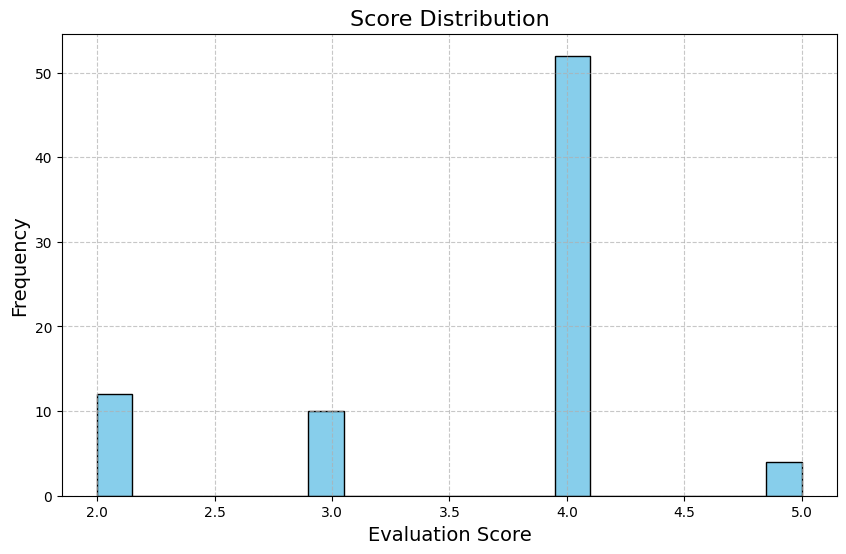

In [42]:
import matplotlib.pyplot as plt

# Assuming df_results is your DataFrame and it contains an "evaluation_score" column.
# You can customize the bins, colors, etc., as needed.

plt.figure(figsize=(10, 6))  # Set the figure size
df_results["evaluation_score"].hist(bins=20, color='skyblue', edgecolor='black')

# Add titles and labels
plt.title("Score Distribution", fontsize=16)
plt.xlabel("Evaluation Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Customize the grid
plt.grid(True, linestyle='--', alpha=0.7)

# Display the plot
plt.show()
